In [1]:
from tensorflow.keras.applications import xception
from tensorflow.keras.applications import resnet50,ResNet50
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# 사전 학습된 신경망 모델을 불러오고 신경망 구조를 확인
model=xception.Xception(weights='imagenet')
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

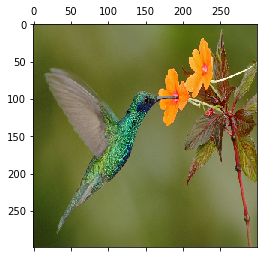

In [3]:
# 지정된 영상을 불러와 크기를 조정하고 화면에 디스플레이
image_path='./hummingbird.jpg'
img=image.load_img(image_path,target_size=(299,299))
plt.matshow(img)

In [4]:
# 영상을 신경망 입력 형태로 변환
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

In [5]:
# 인식을 시도하고 top-5 결과를 출력
preds = model.predict(x)
print("예측 결과:", xception.decode_predictions(preds,top=5)[0])

예측 결과: [('n01833805', 'hummingbird', 0.96300226), ('n01843065', 'jacamar', 0.002827944), ('n01687978', 'agama', 0.0006937465), ('n01682714', 'American_chameleon', 0.0005894132), ('n02268443', 'dragonfly', 0.00047723218)]


In [6]:
# 신경망 모델의 특징 추출(컨볼루션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 만들기
last_conv_layer=model.get_layer("block14_sepconv2_act")
model_1=keras.Model(model.inputs,last_conv_layer.output)

In [7]:
# 분류(전역평균 풀링 또는 완전연결 층) 부분만으로 구성된 모델 model_2 만들기
input_2=keras.Input(shape=last_conv_layer.output.shape[1:])
x_2=model.get_layer("avg_pool")(input_2)
x_2=model.get_layer("predictions")(x_2)
model_2=keras.Model(input_2,x_2)

In [8]:
# GradientTape 함수를 이용한 그레이디언트 계산
with tf.GradientTape() as tape:
    output_1=model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds=model_2(output_1)
    class_id=tf.argmax(preds[0])
    output_2=preds[:,class_id]

In [9]:
grads=tape.gradient(output_2,output_1) # 그레이디언트 계산
pooled_grads=tf.reduce_mean(grads,axis=(0,1,2)) # 식 (12.5) 적용

In [10]:
output_1=output_1.numpy()[0]
pooled_grads=pooled_grads.numpy()

In [11]:
for i in range(pooled_grads.shape[-1]): # 식 (12.6) 적용
    output_1[:,:,i]*=pooled_grads[i]

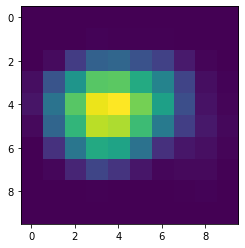

In [12]:
heatmap=np.mean(output_1,axis=-1)
heatmap = np.maximum(heatmap,0) / np.max(heatmap)
plt.imshow(heatmap)

In [13]:
img = image.load_img(image_path)
img=image.img_to_array(img)

In [14]:
heatmap = np.uint8(255*heatmap)  # [0,255]로 변환

In [15]:
jet = cm.get_cmap('jet')

In [16]:
color = jet(np.arange(256))[:,:3]

In [17]:
color_heatmap = color[heatmap]
color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize( (img.shape[1], img.shape[0]) )
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

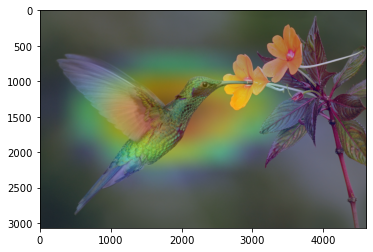

In [18]:
overlay_img=color_heatmap*0.4+img
overlay_img=keras.preprocessing.image.array_to_img(overlay_img)
plt.imshow(overlay_img)